## Installing Packages

In [80]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

## Data Preprocessing

In [81]:
# Create dataframe
df2018flights = pd.read_csv("./Datasets1/2018.csv")

# Remove op_carrier_fl_num, crs_dep_time, dep_time, wheels_off, wheels_on, cancelled, cancellation_co..., diverted, actual_elapsed_..., air_time, unnamed:27
df2018flights = df2018flights.drop(["OP_CARRIER_FL_NUM", "CRS_DEP_TIME", "DEP_TIME", "WHEELS_OFF", "WHEELS_ON", "CANCELLED", "CANCELLATION_CODE", "DIVERTED", "ACTUAL_ELAPSED_TIME", "AIR_TIME", "Unnamed: 27", "ARR_TIME"], axis= 1)

# Create month column
df2018flights["Month"] = pd.DatetimeIndex(df2018flights["FL_DATE"]).month

# Remove date column
df2018flights = df2018flights.drop(["FL_DATE"], axis= 1)

# Add labeled column
df2018flights["Label"] = np.where(df2018flights["ARR_DELAY"] > 0, 1, 0)

# Remove column use to make label
df2018flights = df2018flights.drop(["ARR_DELAY"], axis= 1)

# Airlines to do not fall in hub and spoke or point to point
notRelId = ['9E', 'EV', 'MQ', 'OH', 'OO', 'YV', 'YX']

# Removing from dataframe
mask = ~df2018flights['OP_CARRIER'].isin(notRelId)

# New dataframe without notRel
df2018flights = df2018flights[mask]

# Dummy encode carrier, destination, and origin columns
df2018flights = pd.get_dummies(df2018flights, columns= ["OP_CARRIER", "ORIGIN", "DEST"])

df2018flights.head()

,DEP_DELAY,TAXI_OUT,TAXI_IN,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,...,DEST_TUL,DEST_TUS,DEST_TVC,DEST_TYS,DEST_USA,DEST_VPS,DEST_WRG,DEST_XNA,DEST_YAK,DEST_YNG
0,-5.0,15.0,10.0,1745,268.0,1605.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,-8.0,11.0,7.0,1254,99.0,414.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,-5.0,15.0,5.0,1649,134.0,846.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,6.0,19.0,6.0,1756,190.0,1120.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,20.0,13.0,10.0,922,112.0,723.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [82]:
# Preparing and creating test train split
X = df2018flights.drop(["Label"], axis= 1)
y = df2018flights["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)

## Catboost w/o Probabilities
This section demonstrates the accuracy at which the model can predict a flight being delayed when given binary (delayed or not) values

** Need to do some tuning on the model still **

Confusion matrix:
[[725014  67094]
 [ 65098 363998]]


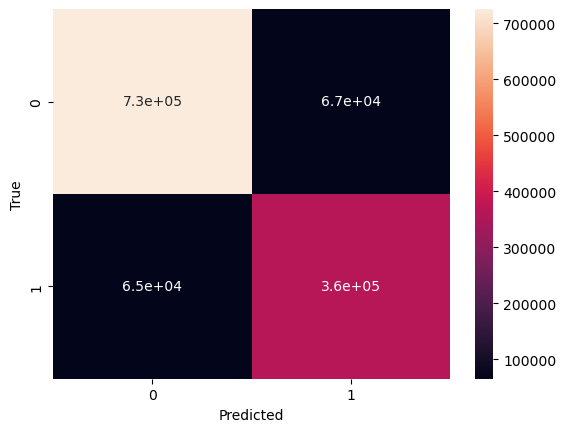

Accuracy: 0.8917527292737332
Precision: 0.8443626882428809
Recall: 0.848290359266924
F1 Score: 0.8463219668258567


In [83]:
## 😸boost ##

# Calculate balance of class weights
import sklearn
weights = sklearn.utils.class_weight.compute_class_weight(class_weight= 'balanced', classes= np.unique(y), y= y)

cb = CatBoostClassifier(iterations=100, random_seed=0, logging_level='Silent', class_weights= weights)
cb.fit(X_train, y_train)

# predict on test set
y_pred = cb.predict(X_test)

# evaluate model performance
conf_mat = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Confusion matrix:")
print(conf_mat)
sns.heatmap(conf_mat, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

In [84]:
# Top predictors of flight being late
importance = cb.get_feature_importance()
cols = X.columns
indices = np.argsort(importance)[::-1]
print("Top Predictors of Upgrade:")
for i in range(X.shape[1]):
    print(f"{cols[indices[i]]}: {importance[indices[i]]}")

Top Predictors of Upgrade:
CARRIER_DELAY: 42.849201718021284
WEATHER_DELAY: 26.54876117483797
DEP_DELAY: 6.191114110464485
NAS_DELAY: 5.433399798966034
TAXI_OUT: 4.764250013966211
TAXI_IN: 3.5272905445812373
CRS_ELAPSED_TIME: 3.2679974397932123
DISTANCE: 2.0255284141071486
LATE_AIRCRAFT_DELAY: 1.1681361066300353
SECURITY_DELAY: 0.951970340788573
Month: 0.45598337417846146
OP_CARRIER_DL: 0.38408216367241355
ORIGIN_LGA: 0.2035482172954414
ORIGIN_JFK: 0.20082293762574865
OP_CARRIER_WN: 0.19332022998190745
OP_CARRIER_HA: 0.12241851551185837
CRS_ARR_TIME: 0.11786030429192557
OP_CARRIER_AA: 0.11618430976921029
DEST_LAX: 0.10499157331368407
DEST_ORD: 0.07046018429889438
OP_CARRIER_G4: 0.07029371203366336
OP_CARRIER_UA: 0.06626750196223653
OP_CARRIER_AS: 0.06343201735844692
ORIGIN_SFO: 0.056304477373465
ORIGIN_LAX: 0.05611229351652273
ORIGIN_SEA: 0.05588332660086001
ORIGIN_ATL: 0.04593688618355265
ORIGIN_ORD: 0.04329412356169135
DEST_DFW: 0.040958911781605746
ORIGIN_EWR: 0.03840304705390744
OR

<strong>Top predictors of a flight being delayed:</strong>
1. Carrier Delay
2. Weather Delay
3. Departure Delay
4. Air System Delay
5. Taxi Out Time
6. Taxi In Time
7. Estimated Arrival Time
8. Distance
9. Late Aircraft Delay

## Catboost with Probabilities
This section gathers the probability at which a flight will be delayed rather than giving it a binary value

** Using the same model as above **

In [85]:
## 😸boost w/o Probabilities##

# Calculate balance of class weights
import sklearn
weights = sklearn.utils.class_weight.compute_class_weight(class_weight= 'balanced', classes= np.unique(y), y= y)

cb = CatBoostClassifier(iterations=100, random_seed=0, logging_level='Silent', class_weights= weights)
cb.fit(X_train, y_train)

# predict probabilities on test set
y_predProba = cb.predict_proba(X_test)[::,1]

print(y_predProba)

[0.05415693 0.1812548  0.18867834 ... 0.53933185 0.00742568 0.99999998]


## Developing New Flight Dataframe w/ Carrier, Origin, Destination, and ProbabilityDelayed

In [86]:
dfXtest = pd.DataFrame(X_test)
dfXtest.head()

,DEP_DELAY,TAXI_OUT,TAXI_IN,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,...,DEST_TUL,DEST_TUS,DEST_TVC,DEST_TYS,DEST_USA,DEST_VPS,DEST_WRG,DEST_XNA,DEST_YAK,DEST_YNG
3585968,-6.0,11.0,8.0,858,118.0,694.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
5311048,-3.0,17.0,5.0,2233,108.0,631.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2280862,-1.0,24.0,7.0,1040,154.0,802.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
812642,35.0,9.0,6.0,2220,210.0,1504.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2119058,-2.0,18.0,4.0,2008,293.0,1931.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [87]:
# Function to pull the locations (origin and destination) from X_test
def pullLocation(df, locType):
    newDict = {}

    df = df.filter(regex= locType).head(250000)

    for index, row in df.iterrows():
        for col in df.columns:
            if row[col] == 1:
                newDict[index] = col.split('_')[1]

    return newDict

# Function to pull the carrier from X_test
def pullCarrier(df):
    newDict = {}

    df = df.filter(regex= 'OP_CARRIER').head(250000)

    for index, row in df.iterrows():
        for col in df.columns:
            if row[col] == 1:
                newDict[index] = col.split('_')[2]

    return newDict

In [88]:
# Creating dataframes with origin location and destination location
dfOrigin = pd.DataFrame(pullLocation(dfXtest, 'ORIGIN').values(), index= pullLocation(dfXtest, 'ORIGIN').keys(), columns= ['Origin'])
dfDest = pd.DataFrame(pullLocation(dfXtest, 'DEST').values(), index= pullLocation(dfXtest, 'DEST').keys(), columns= ['Destination'])

# Creating dataframes with carrier
dfCarrier = pd.DataFrame(pullCarrier(dfXtest).values(), index= pullCarrier(dfXtest).keys(), columns= ["Carrier"])

In [89]:
# Creating dictionary with index as key and probabilities as values
probDict = {val: y_predProba[index] for index, val in enumerate(dfXtest.head(250000).index)}

# Creating dataframe for probabilities
dfProbs = pd.DataFrame(probDict.values(), index= probDict.keys(), columns= ["ProbabilityDelayed"])

In [90]:
# Merging all of these dataframes into one
dfModel = pd.concat([dfCarrier, dfOrigin, dfDest, dfProbs], axis= 1)

In [91]:
dfModel

,Carrier,Origin,Destination,ProbabilityDelayed
3585968,DL,CID,ATL,0.054157
5311048,AA,DFW,BNA,0.181255
2280862,UA,ORD,DFW,0.188678
812642,WN,AUS,EWR,1.000000
2119058,DL,MCO,SLC,0.181247
...,...,...,...,...
5480225,WN,SMF,SNA,0.055822
5695307,AA,ORD,PHX,0.117870
4977957,DL,MSN,MSP,0.000145
927368,WN,TPA,MDW,0.729850


## Performing Aggregations on Flight Routes

In [92]:
dfModel.groupby(['Carrier', 'Origin', 'Destination'])['ProbabilityDelayed'].agg(['count', 'mean'])

count      mean
Carrier Origin Destination                 
AA      ABQ    DFW            104  0.404800
               ORD             28  0.385553
               PHX              6  0.180252
        ALB    CLT             50  0.340622
        ANC    DFW              8  0.469577
...                           ...       ...
WN      TUS    LAX             59  0.472056
               MDW             15  0.164972
               OAK              1  0.014660
               SAN             32  0.318378
               SJC              1  0.874999

[6777 rows x 2 columns]

In [93]:
flightPreds = dfModel.groupby(['Carrier', 'Origin', 'Destination'])['ProbabilityDelayed'].agg(['count', 'mean']).reset_index()
flightPreds = flightPreds.rename(columns= {'count': 'NumFlights', 'mean': 'AvgProbDelayed'})
flightPreds

,Carrier,Origin,Destination,NumFlights,AvgProbDelayed
0,AA,ABQ,DFW,104,0.404800
1,AA,ABQ,ORD,28,0.385553
2,AA,ABQ,PHX,6,0.180252
3,AA,ALB,CLT,50,0.340622
4,AA,ANC,DFW,8,0.469577
...,...,...,...,...,...
6772,WN,TUS,LAX,59,0.472056
6773,WN,TUS,MDW,15,0.164972
6774,WN,TUS,OAK,1,0.014660
6775,WN,TUS,SAN,32,0.318378


In [94]:
# Changing carrier identifiers to names
carrierNamesDict = {'AA': 'American Airlines Inc.', 'AS': 'Alaksa Airlines Inc.', 'B6': 'JetBlue Airways', 'DL': 'Delta Air Lines Inc.', 'F9': 'Frontier Airlines Inc.', 'G4': 'Allegiant Air', 'HA': 'Hawaiian Airlines Inc.', 'NK': 'Spirit Air Lines', 'UA': 'United Air Lines Inc.', 'VX': 'Virgin America', 'WN': 'Southwest Airlines Co.'}
flightPreds['Carrier'] = flightPreds['Carrier'].replace(carrierNamesDict)
flightPreds

,Carrier,Origin,Destination,NumFlights,AvgProbDelayed
0,American Airlines Inc.,ABQ,DFW,104,0.404800
1,American Airlines Inc.,ABQ,ORD,28,0.385553
2,American Airlines Inc.,ABQ,PHX,6,0.180252
3,American Airlines Inc.,ALB,CLT,50,0.340622
4,American Airlines Inc.,ANC,DFW,8,0.469577
...,...,...,...,...,...
6772,Southwest Airlines Co.,TUS,LAX,59,0.472056
6773,Southwest Airlines Co.,TUS,MDW,15,0.164972
6774,Southwest Airlines Co.,TUS,OAK,1,0.014660
6775,Southwest Airlines Co.,TUS,SAN,32,0.318378


In [95]:
# Sorting the dataframe
flightPreds.sort_values(by= ['AvgProbDelayed'], ascending= False)

,Carrier,Origin,Destination,NumFlights,AvgProbDelayed
3849,Allegiant Air,SFB,MEM,1,1.000000
2619,Frontier Airlines Inc.,DEN,ORF,1,1.000000
3014,Frontier Airlines Inc.,RDU,RSW,1,1.000000
6734,Southwest Airlines Co.,TPA,DTW,1,1.000000
2791,Frontier Airlines Inc.,MCO,HSV,1,1.000000
...,...,...,...,...,...
837,Alaksa Airlines Inc.,GST,JNU,1,0.001647
4666,United Air Lines Inc.,EGE,IAD,1,0.000552
4722,United Air Lines Inc.,EWR,SDF,1,0.000546
420,American Airlines Inc.,MIA,BUF,1,0.000408


In [96]:
# Export to csv
flightPreds.to_csv('FlightPreds - AllLate.csv')

## Performing Aggregations on Carriers & Op. Models

### Carriers

In [97]:
carrierPreds = dfModel.groupby(['Carrier'])['ProbabilityDelayed'].agg(['count', 'mean']).reset_index()
carrierPreds = carrierPreds.rename(columns= {'count': 'NumFlights', 'mean': 'AvgProbDelayed'})
carrierPreds

,Carrier,NumFlights,AvgProbDelayed
0,AA,47028,0.421432
1,AS,12508,0.407168
2,B6,15573,0.462872
3,DL,48633,0.321608
4,F9,6140,0.499021
5,G4,4904,0.431472
6,HA,4320,0.381890
7,NK,8950,0.372455
8,UA,31590,0.396357
9,VX,882,0.407636


In [98]:
# Changing carrier identifiers to names
carrierNamesDict = {'AA': 'American Airlines Inc.', 'AS': 'Alaksa Airlines Inc.', 'B6': 'JetBlue Airways', 'DL': 'Delta Air Lines Inc.', 'F9': 'Frontier Airlines Inc.', 'G4': 'Allegiant Air', 'HA': 'Hawaiian Airlines Inc.', 'NK': 'Spirit Air Lines', 'UA': 'United Air Lines Inc.', 'VX': 'Virgin America', 'WN': 'Southwest Airlines Co.'}
carrierPreds['Carrier'] = carrierPreds['Carrier'].replace(carrierNamesDict)
carrierPreds

,Carrier,NumFlights,AvgProbDelayed
0,American Airlines Inc.,47028,0.421432
1,Alaksa Airlines Inc.,12508,0.407168
2,JetBlue Airways,15573,0.462872
3,Delta Air Lines Inc.,48633,0.321608
4,Frontier Airlines Inc.,6140,0.499021
5,Allegiant Air,4904,0.431472
6,Hawaiian Airlines Inc.,4320,0.381890
7,Spirit Air Lines,8950,0.372455
8,United Air Lines Inc.,31590,0.396357
9,Virgin America,882,0.407636


In [99]:
# Sorting the dataframe
carrierPreds.sort_values(by= ['AvgProbDelayed'], ascending= False)

,Carrier,NumFlights,AvgProbDelayed
4,Frontier Airlines Inc.,6140,0.499021
2,JetBlue Airways,15573,0.462872
5,Allegiant Air,4904,0.431472
10,Southwest Airlines Co.,69472,0.429308
0,American Airlines Inc.,47028,0.421432
9,Virgin America,882,0.407636
1,Alaksa Airlines Inc.,12508,0.407168
8,United Air Lines Inc.,31590,0.396357
6,Hawaiian Airlines Inc.,4320,0.381890
7,Spirit Air Lines,8950,0.372455


In [100]:
# Export to csv
carrierPreds.to_csv('CarrierPreds - AllLate.csv')

### Operation Models

In [101]:
# Declaring hub and spoke or point to point
opModelDict = {'American Airlines Inc.': 'HubSpoke', 'Alaksa Airlines Inc.': 'PointPoint', 'JetBlue Airways': 'PointPoint', 'Delta Air Lines Inc.': 'HubSpoke', 'Frontier Airlines Inc.': 'PointPoint', 'Allegiant Air': 'PointPoint', 'Hawaiian Airlines Inc.': 'PointPoint', 'Spirit Air Lines': 'PointPoint', 'United Air Lines Inc.': 'HubSpoke', 'Virgin America': 'PointPoint', 'Southwest Airlines Co.': 'PointPoint'}

dfOpModel = dfModel.copy()
dfOpModel['Carrier'] = dfOpModel['Carrier'].replace(carrierNamesDict)
dfOpModel['OpModel'] = dfOpModel['Carrier'].replace(opModelDict)
dfOpModel

,Carrier,Origin,Destination,ProbabilityDelayed,OpModel
3585968,Delta Air Lines Inc.,CID,ATL,0.054157,HubSpoke
5311048,American Airlines Inc.,DFW,BNA,0.181255,HubSpoke
2280862,United Air Lines Inc.,ORD,DFW,0.188678,HubSpoke
812642,Southwest Airlines Co.,AUS,EWR,1.000000,PointPoint
2119058,Delta Air Lines Inc.,MCO,SLC,0.181247,HubSpoke
...,...,...,...,...,...
5480225,Southwest Airlines Co.,SMF,SNA,0.055822,PointPoint
5695307,American Airlines Inc.,ORD,PHX,0.117870,HubSpoke
4977957,Delta Air Lines Inc.,MSN,MSP,0.000145,HubSpoke
927368,Southwest Airlines Co.,TPA,MDW,0.729850,PointPoint


In [102]:
opModelPreds = dfOpModel.groupby(['OpModel'])['ProbabilityDelayed'].agg(['count', 'mean']).reset_index()
opModelPreds = opModelPreds.rename(columns= {'count': 'NumFlights', 'mean': 'AvgProbDelayed'})
opModelPreds

,OpModel,NumFlights,AvgProbDelayed
0,HubSpoke,127251,0.377056
1,PointPoint,122749,0.428914


In [103]:
# Sorting the dataframe
opModelPreds.sort_values(by= ['AvgProbDelayed'], ascending= False)

,OpModel,NumFlights,AvgProbDelayed
1,PointPoint,122749,0.428914
0,HubSpoke,127251,0.377056


In [104]:
# Export to csv
opModelPreds.to_csv('OpModelPreds - AllLate.csv')